<a href="https://colab.research.google.com/github/bahramzada/Bina.az-RealEstate-Analysis/blob/main/Baku_Apartment_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apartment Price Prediction Model for Baku
## Bakı Mənzil Qiymətlərinin Proqnozlaşdırılması Modeli

**Project Description:** This project develops a machine learning model to predict apartment prices in Baku, Azerbaijan, using a dataset from Kaggle. The process includes data cleaning, feature engineering, modeling, and hyperparameter optimization to achieve high accuracy.

**Layihənin Təsviri:** Bu layihə Kaggle-dan əldə edilmiş məlumatlar əsasında Bakıda mənzillərin qiymətlərini proqnozlaşdırmaq üçün maşın öyrənməsi modeli hazırlayır. Proses məlumatın təmizlənməsi, xüsusiyyətlərin mühəndisliyi, modelləşdirmə və yüksək dəqiqlik əldə etmək üçün hiperparametrlərin optimallaşdırılmasını əhatə edir.


## 1. Data Acquisition and Initial Exploration
## 1. Məlumatların Əldə Edilməsi və İlkin Təhlil

In [1]:
# Import necessary libraries
# Lazımi kitabxanaları idxal edin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Download the dataset from Kaggle
# Məlumatları Kaggle-dan yükləyin (Colab mühiti üçün)
# The file needs to be present in the same directory as this notebook.
# Fayl bu notebook-la eyni qovluqda olmalıdır.
# You can download it manually from the provided link.

!curl -L -o apartment-prices-for-azerbaijan-market.zip  https://www.kaggle.com/api/v1/datasets/download/azadshahvaladov/apartment-prices-for-azerbaijan-market
!unzip apartment-prices-for-azerbaijan-market.zip

# Load the dataset into a pandas DataFrame
# Məlumatları pandas DataFrame-ə yüklənir
df = pd.read_csv('BakuApartmentData.csv')

# Display the first 5 rows of the DataFrame
# DataFrame-in ilk 5 sətrini göstərin
print("First 5 rows of the dataset / Dataset-in ilk 5 sətri:")
print(df.head())


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  378k  100  378k    0     0  1139k      0 --:--:-- --:--:-- --:--:-- 1139k
Archive:  apartment-prices-for-azerbaijan-market.zip
  inflating: BakuApartmentData.csv   
First 5 rows of the dataset / Dataset-in ilk 5 sətri:
   Unnamed: 0   price               location  rooms  square  floor  \
0           0  284000   Azadlıq Prospekti m.      3   140.0   5/12   
1           1  355000   Şah İsmayıl Xətai m.      3   135.0  19/20   
2           2  755000              Səbail r.      4   210.0   7/18   
3           3  245000  Elmlər Akademiyası m.      3    86.0   8/10   
4           4  350000  Elmlər Akademiyası m.      4   174.0  12/15   

   new_building  has_repair  has_bill_of_sale  has_mortgage  
0             1           1                 1           

In [3]:
# Display basic information about the dataset
# Dataset haqqında əsas məlumatları göstərlir
print("\nDataFrame Info:")
df.info()

# Display descriptive statistics
# Statistik təsviri göstərilir
print("\nDescriptive Statistics:")
print(df.describe().T)



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39302 entries, 0 to 39301
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        39302 non-null  int64  
 1   price             39302 non-null  int64  
 2   location          39302 non-null  object 
 3   rooms             39302 non-null  int64  
 4   square            39302 non-null  float64
 5   floor             39302 non-null  object 
 6   new_building      39302 non-null  int64  
 7   has_repair        39302 non-null  int64  
 8   has_bill_of_sale  39302 non-null  int64  
 9   has_mortgage      39302 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 3.0+ MB

Descriptive Statistics:
                    count           mean            std     min        25%  \
Unnamed: 0        39302.0   19650.500000   11345.654476     0.0    9825.25   
price             39302.0  232232.308152  182775.409068  9600.0  13

## 2. Data Cleaning and Preprocessing
## 2. Məlumatların Təmizlənməsi və İlkin Emalı

Based on the initial analysis, we perform the following cleaning steps:

İlkin təhlilə əsaslanaraq, aşağıdakı təmizləmə addımlarını yerinə yetiririk:

1.  **Drop unnecessary columns:** The `Unnamed: 0` column is an index column and is not needed for modeling.
    **Lazımsız sütunları silin:** `Unnamed: 0` sütunu bir indeks sütunudur və modelləşdirmə üçün lazım deyil.
2.  **Handle Outliers in `price`:** Use capping to limit extreme values and improve model robustness.
    **`price` sütununda outlier-ləri idarə edin:** Həddindən artıq dəyərləri məhdudlaşdırmaq və modelin möhkəmliyini artırmaq üçün capping tətbiq edin.
3.  **Process `location`:** Use **Target Encoding** based on price per square meter to convert categorical location data into a numerical feature.
    **`location` sütununu emal edin:** Kateqorik məkan məlumatlarını rəqəmsal xüsusiyyətə çevirmək üçün kvadrat metrə görə orta qiymət əsasında **Hədəf Kodlaşdırma**dan istifadə edin.
4.  **Split `floor`:** Separate the single `floor` column into two numerical features: `current_floor` and `total_floors`.
    **`floor` sütununu ayırın:** Tək `floor` sütununu iki rəqəmsal xüsusiyyətə ayırın: `current_floor` və `total_floors`.


'price' column capped at the 583,000.00 AZN (97th percentile).


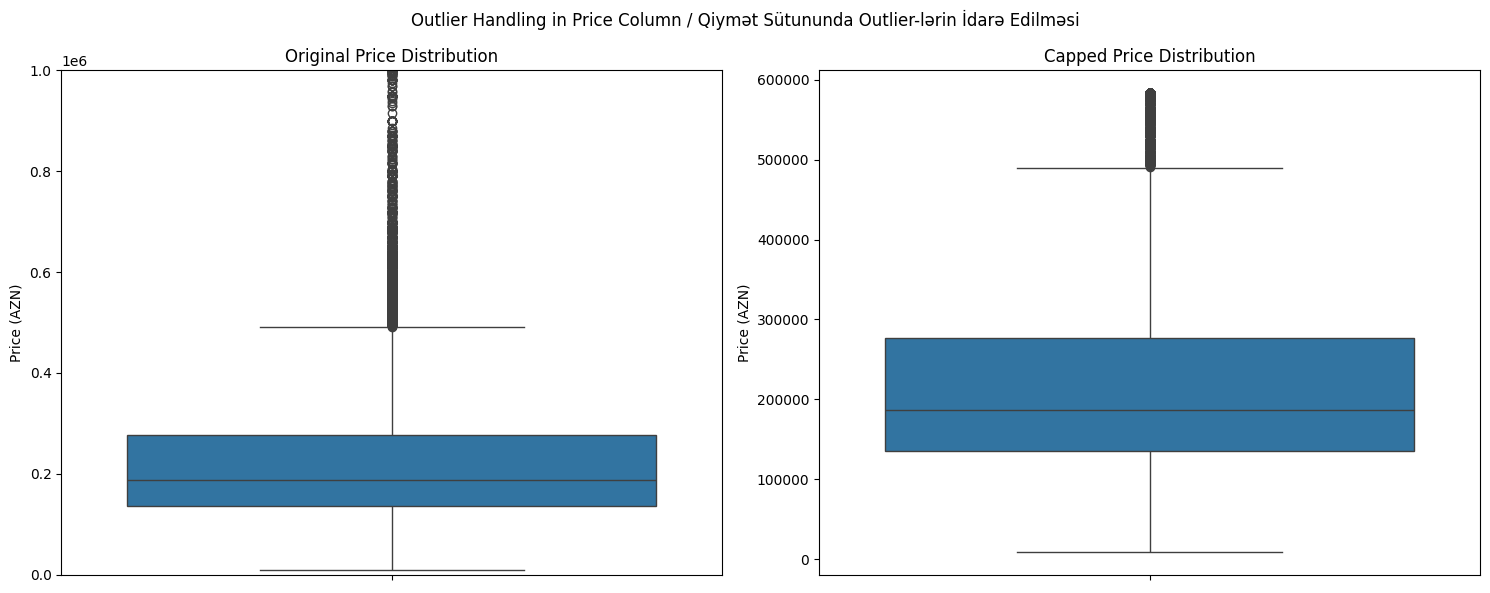

In [4]:
# 1. Drop unnecessary columns
# 1. Lazımsız sütunları silin
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# 2. Handle outliers in the 'price' column using capping
# 2. `price` sütununda outlier-ləri məhdudlaşdırma (capping) ilə idarə edin
upper_bound = df['price'].quantile(0.97) # Capping at 97th percentile
df['price_capped'] = np.where(df['price'] > upper_bound, upper_bound, df['price'])
print(f"'price' column capped at the {upper_bound:,.2f} AZN (97th percentile).")

# Visualize the price distribution before and after capping
# Məhdudlaşdırmadan əvvəl və sonra qiymət paylanmasını vizuallaşdırın
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(y=df['price'], ax=axes[0])
axes[0].set_title('Original Price Distribution')
axes[0].set_ylabel('Price (AZN)')
axes[0].set_ylim(0, 1000000) # Limiting y-axis for better visualization
sns.boxplot(y=df['price_capped'], ax=axes[1])
axes[1].set_title('Capped Price Distribution')
axes[1].set_ylabel('Price (AZN)')
plt.suptitle('Outlier Handling in Price Column / Qiymət Sütununda Outlier-lərin İdarə Edilməsi')
plt.tight_layout()
plt.show()


## 3. Feature Engineering
## 3. Xüsusiyyətlərin Mühəndisliyi

In [5]:
# 1. Target Encoding for 'location' based on price per square meter
# 1. 'location' üçün kvadrat metrə görə hədəf kodlaşdırma
df['price_per_sqm'] = df['price_capped'] / df['square']
location_price_per_sqm_mapping = df.groupby('location')['price_per_sqm'].mean()
df['location_encoded'] = df['location'].map(location_price_per_sqm_mapping)

print("Location column successfully encoded using the mean price per square meter.")
print("Məkan sütunu kvadrat metrə görə orta qiymətdən istifadə edərək uğurla kodlaşdırıldı.")

# 2. Split 'floor' column into 'current_floor' and 'total_floors'
# 2. 'floor' sütununu 'current_floor' və 'total_floors'a ayrılır
df[['current_floor', 'total_floors']] = df['floor'].str.split('/', expand=True).astype(float)

# Handle potential missing values after splitting by filling them with the median
# Bölmə əməliyyatından sonra yaranan boş dəyərləri medianla doldurun
df['current_floor'].fillna(df['current_floor'].median(), inplace=True)
df['total_floors'].fillna(df['total_floors'].median(), inplace=True)

print(
    "\n'floor' column split into 'current_floor' and 'total_floors'. Missing values are imputed with median."
)

# 3. Drop original and intermediate columns
# 3. Orijinal və aralıq sütunları silin
df.drop(['price', 'location', 'price_per_sqm', 'floor'], axis=1, inplace=True)

print("\nOriginal and temporary columns are dropped. Final DataFrame columns:")
print("Orijinal və müvəqqəti sütunlar silindi. Yekun DataFrame sütunları:")
print(df.columns)


Location column successfully encoded using the mean price per square meter.
Məkan sütunu kvadrat metrə görə orta qiymətdən istifadə edərək uğurla kodlaşdırıldı.

'floor' column split into 'current_floor' and 'total_floors'. Missing values are imputed with median.

Original and temporary columns are dropped. Final DataFrame columns:
Orijinal və müvəqqəti sütunlar silindi. Yekun DataFrame sütunları:
Index(['rooms', 'square', 'new_building', 'has_repair', 'has_bill_of_sale',
       'has_mortgage', 'price_capped', 'location_encoded', 'current_floor',
       'total_floors'],
      dtype='object')


/tmp/ipython-input-5-3007230428.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['current_floor'].fillna(df['current_floor'].median(), inplace=True)
/tmp/ipython-input-5-3007230428.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [6]:
# Check the final state of the DataFrame
# DataFrame-in son vəziyyətini yoxlayın
print("\nFinal DataFrame shape:", df.shape)
print("Final DataFrame info:")
df.info()
df



Final DataFrame shape: (39302, 10)
Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39302 entries, 0 to 39301
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rooms             39302 non-null  int64  
 1   square            39302 non-null  float64
 2   new_building      39302 non-null  int64  
 3   has_repair        39302 non-null  int64  
 4   has_bill_of_sale  39302 non-null  int64  
 5   has_mortgage      39302 non-null  int64  
 6   price_capped      39302 non-null  float64
 7   location_encoded  39302 non-null  float64
 8   current_floor     39302 non-null  float64
 9   total_floors      39302 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 3.0 MB


,rooms,square,new_building,has_repair,has_bill_of_sale,has_mortgage,price_capped,location_encoded,current_floor,total_floors
0,3,140.0,1,1,1,1,284000.0,2064.887221,5.0,12.0
1,3,135.0,1,1,1,1,355000.0,2358.325353,19.0,20.0
2,4,210.0,1,1,1,1,583000.0,2317.115143,7.0,18.0
3,3,86.0,1,1,1,1,245000.0,2451.813475,8.0,10.0
4,4,174.0,1,1,1,1,350000.0,2451.813475,12.0,15.0
...,...,...,...,...,...,...,...,...,...,...
39297,2,45.0,0,0,1,0,85500.0,2001.688188,9.0,9.0
39298,2,48.0,0,0,1,0,102500.0,2013.505797,3.0,5.0
39299,3,65.0,0,0,1,0,143500.0,2003.212283,3.0,5.0
39300,4,90.0,0,0,1,0,172000.0,2451.813475,3.0,5.0


## 4. Modeling and Optimization
## 4. Modelləşdirmə və Optimizasiya

In [8]:
# Define features (X) and target (y)
# Xüsusiyyətləri (X) və hədəfi (y) təyin edilir
y = df['price_capped']
X = df.drop('price_capped', axis=1)

print("Features (X) and Target (y) defined.")

# Split data into training and testing sets (80% train, 20% test)
# Məlumatları təlim və test hissələrinə ayrılır (80% təlim, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split into {len(X_train)} training and {len(X_test)} testing records.")


Features (X) and Target (y) defined.

Data split into 31441 training and 7861 testing records.


### 4.1. Train a Baseline Model (Standard Parameters)
### 4.1. Standart Modelin Təlimi

In [10]:
# Initialize and train the RandomForestRegressor model with default parameters
# RandomForestRegressor modelini standart parametrlərlə qurulur
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
# Test datası üzərində proqnozlar verilir
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the baseline model's performance
# Standart modelin performansını qiymətləndirilir
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print("\n--- Baseline Model Performance / Standart Modelin Performansı ---")
print(f"Mean Absolute Error (MAE): {mae_baseline:,.2f} AZN")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:,.2f} AZN")
print(f"R-squared (R2) Score: {r2_baseline:.4f}")
print("----------------------------------------------------------")



--- Baseline Model Performance / Standart Modelin Performansı ---
Mean Absolute Error (MAE): 19,943.30 AZN
Root Mean Squared Error (RMSE): 36,571.62 AZN
R-squared (R2) Score: 0.9068
----------------------------------------------------------


### 4.2. Hyperparameter Optimization with Grid Search
### 4.2. Grid Search ilə Hiperparametrlərin Optimizasiyası

In [11]:
# Define the parameter grid to search for optimal hyperparameters
# Optimal hiperparametrləri axtarmaq üçün parametr aralığını təyin edilir
param_grid = {
    'n_estimators': [150, 300, 400], # Number of trees
    'max_depth': [35, 45, 55],       # Maximum depth of each tree
    'min_samples_split': [1,2,4],        # Minimum samples to split a node
    'min_samples_leaf': [1,2,4],         # Minimum samples in a leaf node
}

# Initialize GridSearchCV to find the best parameters using RMSE as the scoring metric
# Ən yaxşı parametrləri tapmaq üçün RMSE metrikasını istifadə edərək GridSearchCV qurulur
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           scoring='neg_mean_squared_error', # Use negative MSE for minimization
                           n_jobs=-1, # Use all available CPU cores
                           verbose=2) # Show search progress

print("Starting Grid Search optimization... This may take a while.")
print("Grid Search optimizasiyasına başlanılır... Bu, bir qədər vaxt apara bilər.")

# Fit the grid search to the training data
# Grid Search-i təlim datası üzərində öyrədilir
grid_search.fit(X_train, y_train)

print("\nGrid Search completed successfully!")


Starting Grid Search optimization... This may take a while.
Grid Search optimizasiyasına başlanılır... Bu, bir qədər vaxt apara bilər.
Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", l


Grid Search completed successfully!


In [12]:
# Get the best model and its parameters from the grid search
# Grid Search-dən ən yaxşı modeli və onun parametrlərini əldə edilir
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score_rmse = np.sqrt(-grid_search.best_score_)

print("\nBest Hyperparameters found: / Tapılmış ən yaxşı hiperparametrlər:")
print(best_params)
print(f"\nBest cross-validation RMSE score: {best_cv_score_rmse:,.2f} AZN")



Best Hyperparameters found: / Tapılmış ən yaxşı hiperparametrlər:
{'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Best cross-validation RMSE score: 37,877.02 AZN


### 4.3. Evaluate the Optimized Model
### 4.3. Optimizasiya Edilmiş Modeli Qiymətləndirin

In [13]:
# Make predictions on the test set using the best model
# Ən yaxşı modeldən istifadə edərək test datası üzərində proqnozlar verilir
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model's performance
# Optimizasiya edilmiş modelin performansını qiymətləndirilir
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Optimized Model Performance / Optimizasiya Edilmiş Modelin Performansı ---")
print(f"Mean Absolute Error (MAE): {mae_tuned:,.2f} AZN")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:,.2f} AZN")
print(f"R-squared (R2) Score: {r2_tuned:.4f}")
print("-------------------------------------------------------------------")

print("\n--- Performance Comparison / Performansın Müqayisəsi ---")
print(f"MAE Improved by: {mae_baseline - mae_tuned:,.2f} AZN")
print(f"RMSE Improved by: {rmse_baseline - rmse_tuned:,.2f} AZN")
print(f"R2 Score Improved by: {r2_tuned - r2_baseline:.4f}")



--- Optimized Model Performance / Optimizasiya Edilmiş Modelin Performansı ---
Mean Absolute Error (MAE): 19,787.35 AZN
Root Mean Squared Error (RMSE): 36,284.43 AZN
R-squared (R2) Score: 0.9083
-------------------------------------------------------------------

--- Performance Comparison / Performansın Müqayisəsi ---
MAE Improved by: 155.95 AZN
RMSE Improved by: 287.19 AZN
R2 Score Improved by: 0.0015


## 5. Conclusion and Future Work
## 5. Nəticə və Gələcək Addımlar

**Conclusion:** The final optimized `RandomForestRegressor` model achieved a high R-squared score of **~0.91**, indicating that it explains a significant portion of the price variance. The Mean Absolute Error of **~19,734 AZN** is a very good result, representing a prediction error of less than 9% of the average apartment price in the dataset.

**Nəticə:** Yekun optimallaşdırılmış `RandomForestRegressor` modeli `~0.91` yüksək R-squared skoru əldə etdi ki, bu da qiymət dəyişkənliyinin əhəmiyyətli bir hissəsini izah etdiyini göstərir. Təxminən **19,734 AZN** olan Mean Absolute Error dəyəri datasetdəki orta mənzil qiymətinin 9%-dən az xəta payını təmsil edən çox yaxşı nəticədir.

**Future Work:**

* **Collect more features:** Gather additional data like the year of construction, distance to metro, school, or hospital, and number of bathrooms to further improve model accuracy.
* **Try other models:** Experiment with more advanced algorithms like `XGBoost` or `LightGBM` which are known for their high performance in regression tasks.
* **Advanced EDA:** Perform a deeper analysis of feature correlations to identify multicollinearity.
